In [1]:
import pandas as pd
import re
# Load Reading Girls Data
df = pd.read_csv("data/SessionPlaytestResults.csv")

original_before_words = []
for a in pd.concat([df['Being a scientist means....Pre'+str(i)] for i in range(1,6)]).fillna(''):
    original_before_words = original_before_words + a.split()
    
original_before_words = [re.sub(r'[^\w\s]', '', x.lower()) for x in original_before_words] 

original_after_words = []
for a in pd.concat([df['Being a scientist means....Post'+str(i)] for i in range(1,6)]).fillna(''):
    original_after_words = original_after_words + a.split()

original_after_words = [re.sub(r'[^\w\s]', '', x.lower()) for x in original_after_words]

In [2]:
# Load Reading Girls Data
df = pd.read_csv("data/RGS_raw_feedback.csv")

rgs_before_words = []
for a in df['Being a scientist means? Before'].fillna(''):
    rgs_before_words = rgs_before_words + a.split()
    
rgs_before_words = [re.sub(r'[^\w\s]', '', x.lower()) for x in rgs_before_words] 

rgs_after_words = []
for a in df['Being a scientist means? After'].fillna(''):
    rgs_after_words = rgs_after_words + a.split()

rgs_after_words = [re.sub(r'[^\w\s]', '', x.lower()) for x in rgs_after_words] 

In [3]:
# Load Print and play data
df = pd.read_csv("data/Questionaire_Responces.csv")

pnp_before_words = []
for a in df['Q5'].fillna(''):
    pnp_before_words = pnp_before_words + a.split()

pnp_before_words = [re.sub(r'[^\w\s]', '', x.lower()) for x in pnp_before_words] 

In [4]:
from wordcloud import WordCloud, STOPWORDS
import numpy as np

x, y = np.ogrid[:3000, :3000]

mask = (x - 1500) ** 2 + (y - 1500) ** 2 > 1300 ** 2
mask = 255 * mask.astype(int)
mask = mask[::2,:]

wordcloud = WordCloud(width=3000,
                    height=2000,
                    random_state=1, 
                    background_color='white',
                    mask=mask,
                    colormap='viridis', 
                    collocations=False, 
                    stopwords=STOPWORDS)

In [5]:
import urllib.request, json 
sentiment_url = 'https://hedonometer.org/api/v1/words/?format=json&wordlist__title=labMT-en-v2'
raw_sentiment = None
with urllib.request.urlopen(sentiment_url) as url:
    raw_sentiment = json.loads(url.read().decode())

In [6]:
sentiment = {}
for item in raw_sentiment['objects']:
    sentiment[item['word']] = (item['happs'], item['stdDev'])

In [7]:
import pandas as pd
def create_top_word_dataframe(wordcloud, words, number_of_top_words=20):
    data = []
    data.append(['laughter', None, sentiment['laughter'][0], None, sentiment['laughter'][0]])
    for i in range(number_of_top_words):
        word = list(wordcloud.words_.keys())[i]
        value = words.count(word) + words.count(word+'s')
        happy_s, happy_std = (None, None)
        if word in sentiment:
            happy_s, happy_std = sentiment[word]
        data.append([word, value, happy_s, happy_std, None])
    # Create the pandas DataFrame
    data.append(['sadness', None, sentiment['sadness'][0], None, sentiment['sadness'][0]])
    df = pd.DataFrame(data, columns = ['Word', 'Times used', 'Happiness Score', 'Happiness StDev', 'Examples'])
    df['Weighted mean'] = (df['Times used'] * df['Happiness Score']).sum() / (df['Times used'] * df['Happiness Score']/df['Happiness Score']).sum()
    return df

In [8]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl

def plot_word_analysis(data_frame, save_name):
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    ax2=ax.twinx()

    ax.bar(data_frame['Word'],data_frame['Happiness Score'], color=pl.cm.viridis(0.2), label='Happiness Score')
    ax.bar(data_frame['Word'],data_frame['Examples'], color=pl.cm.viridis(0.4), label='Examples', hatch='//')
    ax2.scatter(data_frame['Word'],data_frame['Times used'], color=pl.cm.viridis(0.9), marker='D', label='Times Used')
    ax.plot(data_frame['Word'],data_frame['Weighted mean'], color=pl.cm.viridis(0.6), label='Weighted Mean')
    ax.set_xlabel('Word')
    ax.set_ylabel('Happiness Score')
    ax2.set_ylabel('Number of times seen')
    ax.set_title("The happiness score and occurence of the top 20 answers to the pre-survey question\n‘Being a Scientist Means?’, with ‘Laughter’ and ‘Sadness’ values provided as references.")

    # Tweak spacing to prevent clipping of ylabel
    fig.tight_layout()
    plt.setp(ax.get_xticklabels(), rotation=60, ha="right", va='center',
             rotation_mode="anchor")

    #legend
    handles, labels = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles += handles2
    labels += labels2
    plt.legend(handles, labels)
    plt.tight_layout()
    plt.savefig('figures/'+save_name+'.png')
    plt.show()

In [9]:
wordcloud.generate(' '.join(original_before_words))
original_df_before = create_top_word_dataframe(wordcloud, original_before_words)
original_df_before

,Word,Times used,Happiness Score,Happiness StDev,Examples,Weighted mean
0,laughter,NaN,8.50,NaN,8.50,6.115644
1,experiment,16.0,5.76,1.27,NaN,6.115644
2,research,12.0,6.46,1.09,NaN,6.115644
3,smart,11.0,7.48,1.37,NaN,6.115644
4,things,7.0,5.76,0.94,NaN,6.115644
5,innovation,5.0,NaN,NaN,NaN,6.115644
6,creative,5.0,7.40,1.20,NaN,6.115644
7,discovering,5.0,NaN,NaN,NaN,6.115644
8,new,5.0,6.82,1.14,NaN,6.115644
9,solving,5.0,6.04,1.74,NaN,6.115644


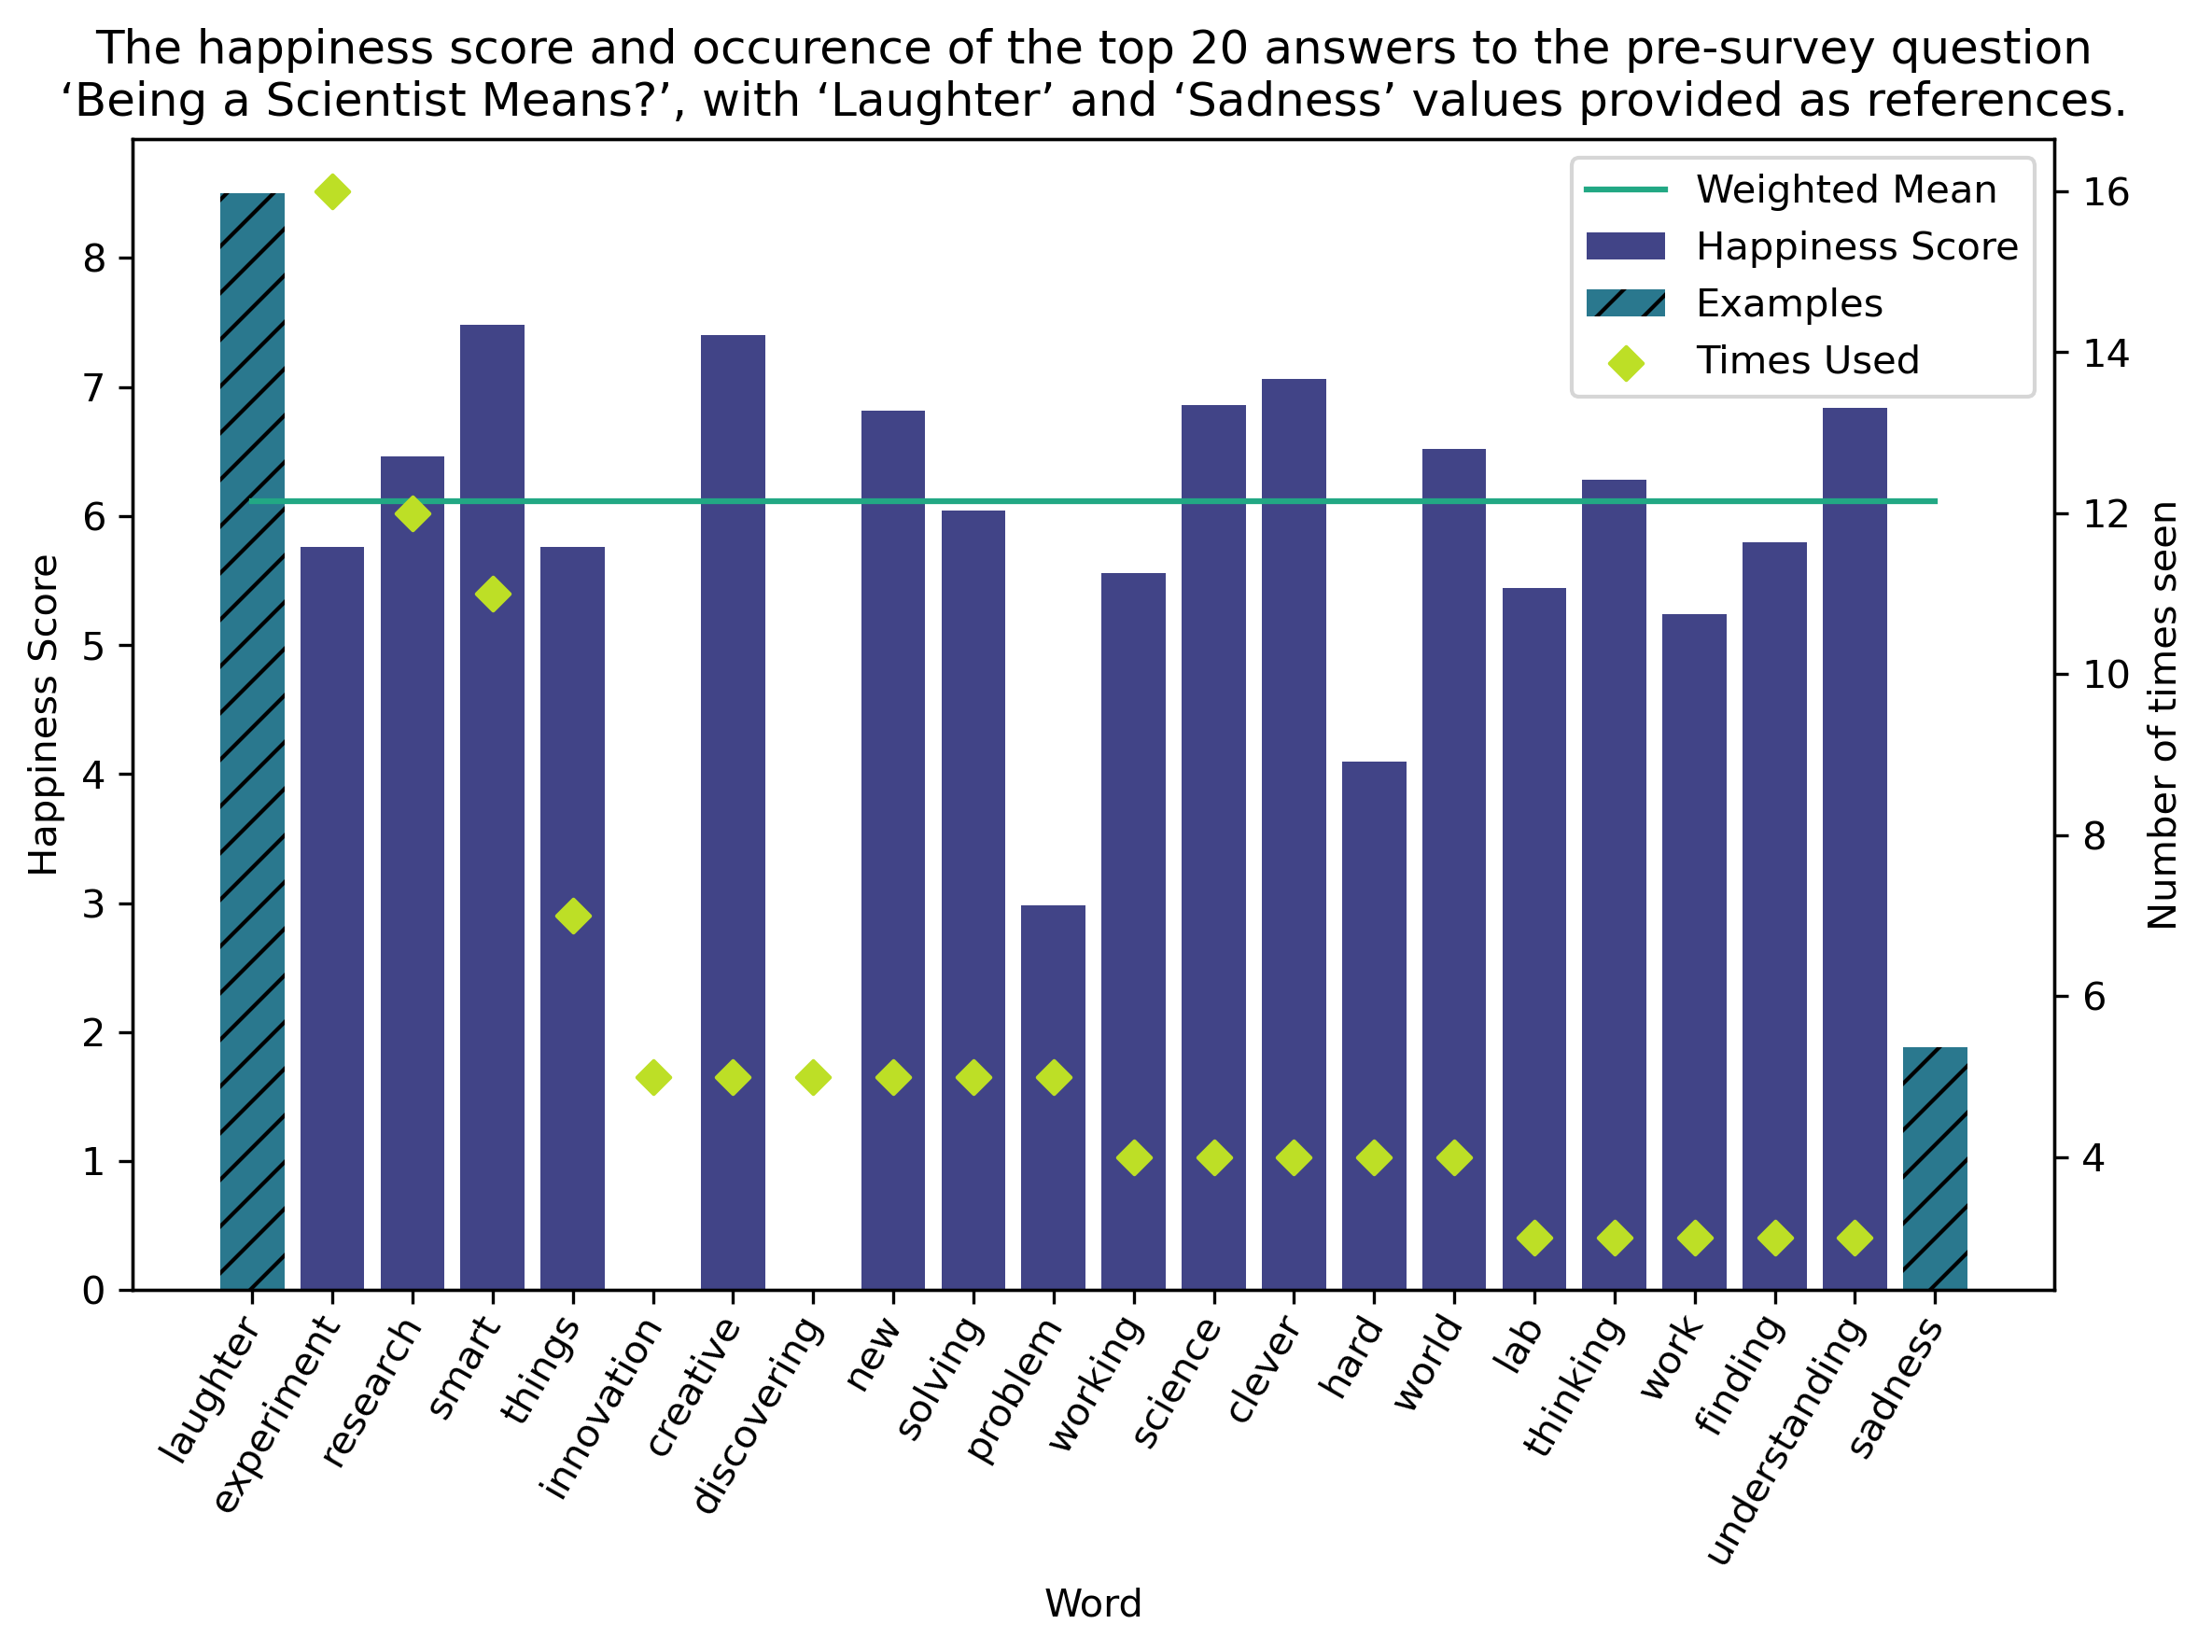

In [10]:
plot_word_analysis(original_df_before, 'OriginalWordAnalysisBefore')

In [11]:
wordcloud.generate(' '.join(original_after_words))
original_df_after = create_top_word_dataframe(wordcloud, original_after_words)
original_df_after

,Word,Times used,Happiness Score,Happiness StDev,Examples,Weighted mean
0,laughter,NaN,8.50,NaN,8.50,5.556667
1,failure,8.0,2.06,1.22,NaN,5.556667
2,collaboration,5.0,NaN,NaN,NaN,5.556667
3,success,4.0,7.86,1.64,NaN,5.556667
4,research,3.0,6.46,1.09,NaN,5.556667
5,luck,2.0,7.26,1.88,NaN,5.556667
6,finding,2.0,5.80,1.21,NaN,5.556667
7,things,2.0,5.76,0.94,NaN,5.556667
8,fun,2.0,7.96,1.31,NaN,5.556667
9,new,2.0,6.82,1.14,NaN,5.556667


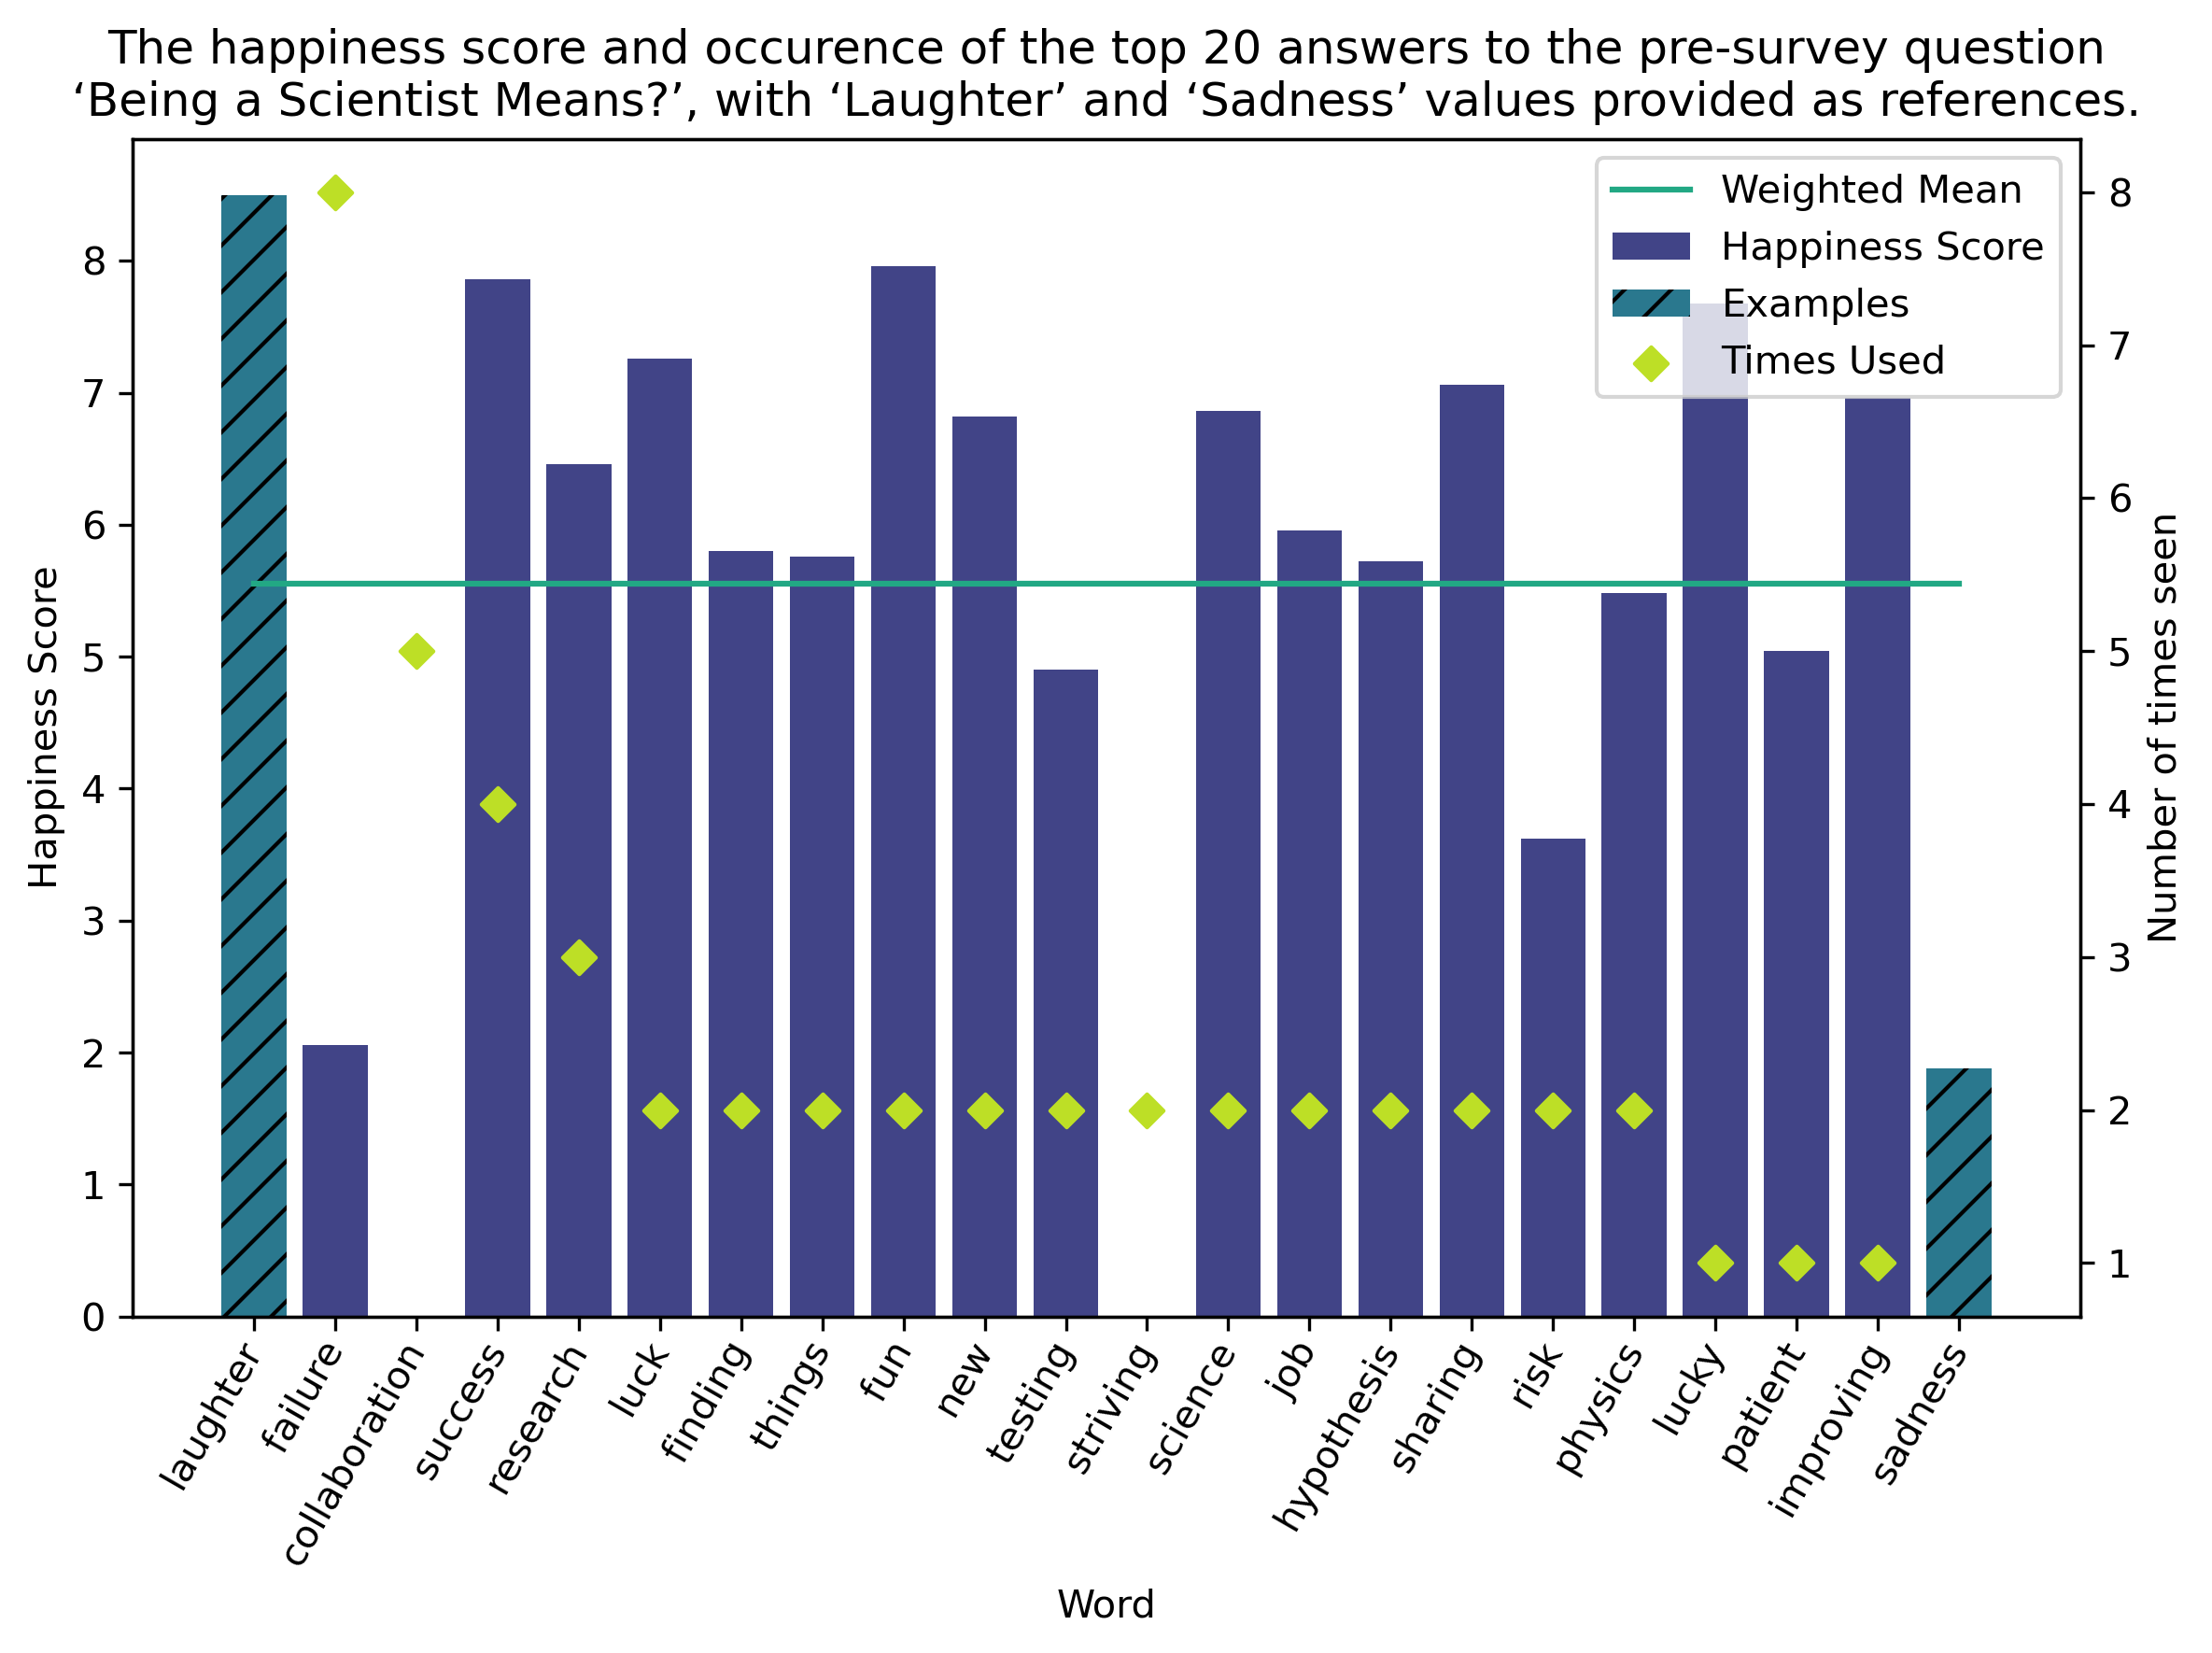

In [12]:
plot_word_analysis(original_df_after, 'OriginalWordAnalyisAfter')

In [13]:
wordcloud.generate(' '.join(rgs_before_words))
rgs_df_before = create_top_word_dataframe(wordcloud, rgs_before_words)
rgs_df_before

,Word,Times used,Happiness Score,Happiness StDev,Examples,Weighted mean
0,laughter,NaN,8.50,NaN,8.50,6.022213
1,thing,31.0,5.58,1.01,NaN,6.022213
2,experiment,29.0,5.76,1.27,NaN,6.022213
3,discover,19.0,6.84,1.40,NaN,6.022213
4,new,18.0,6.82,1.14,NaN,6.022213
5,knowledge,15.0,7.24,1.46,NaN,6.022213
6,smart,14.0,7.48,1.37,NaN,6.022213
7,stuff,13.0,5.58,1.50,NaN,6.022213
8,potions,12.0,NaN,NaN,NaN,6.022213
9,fact,12.0,5.90,1.33,NaN,6.022213


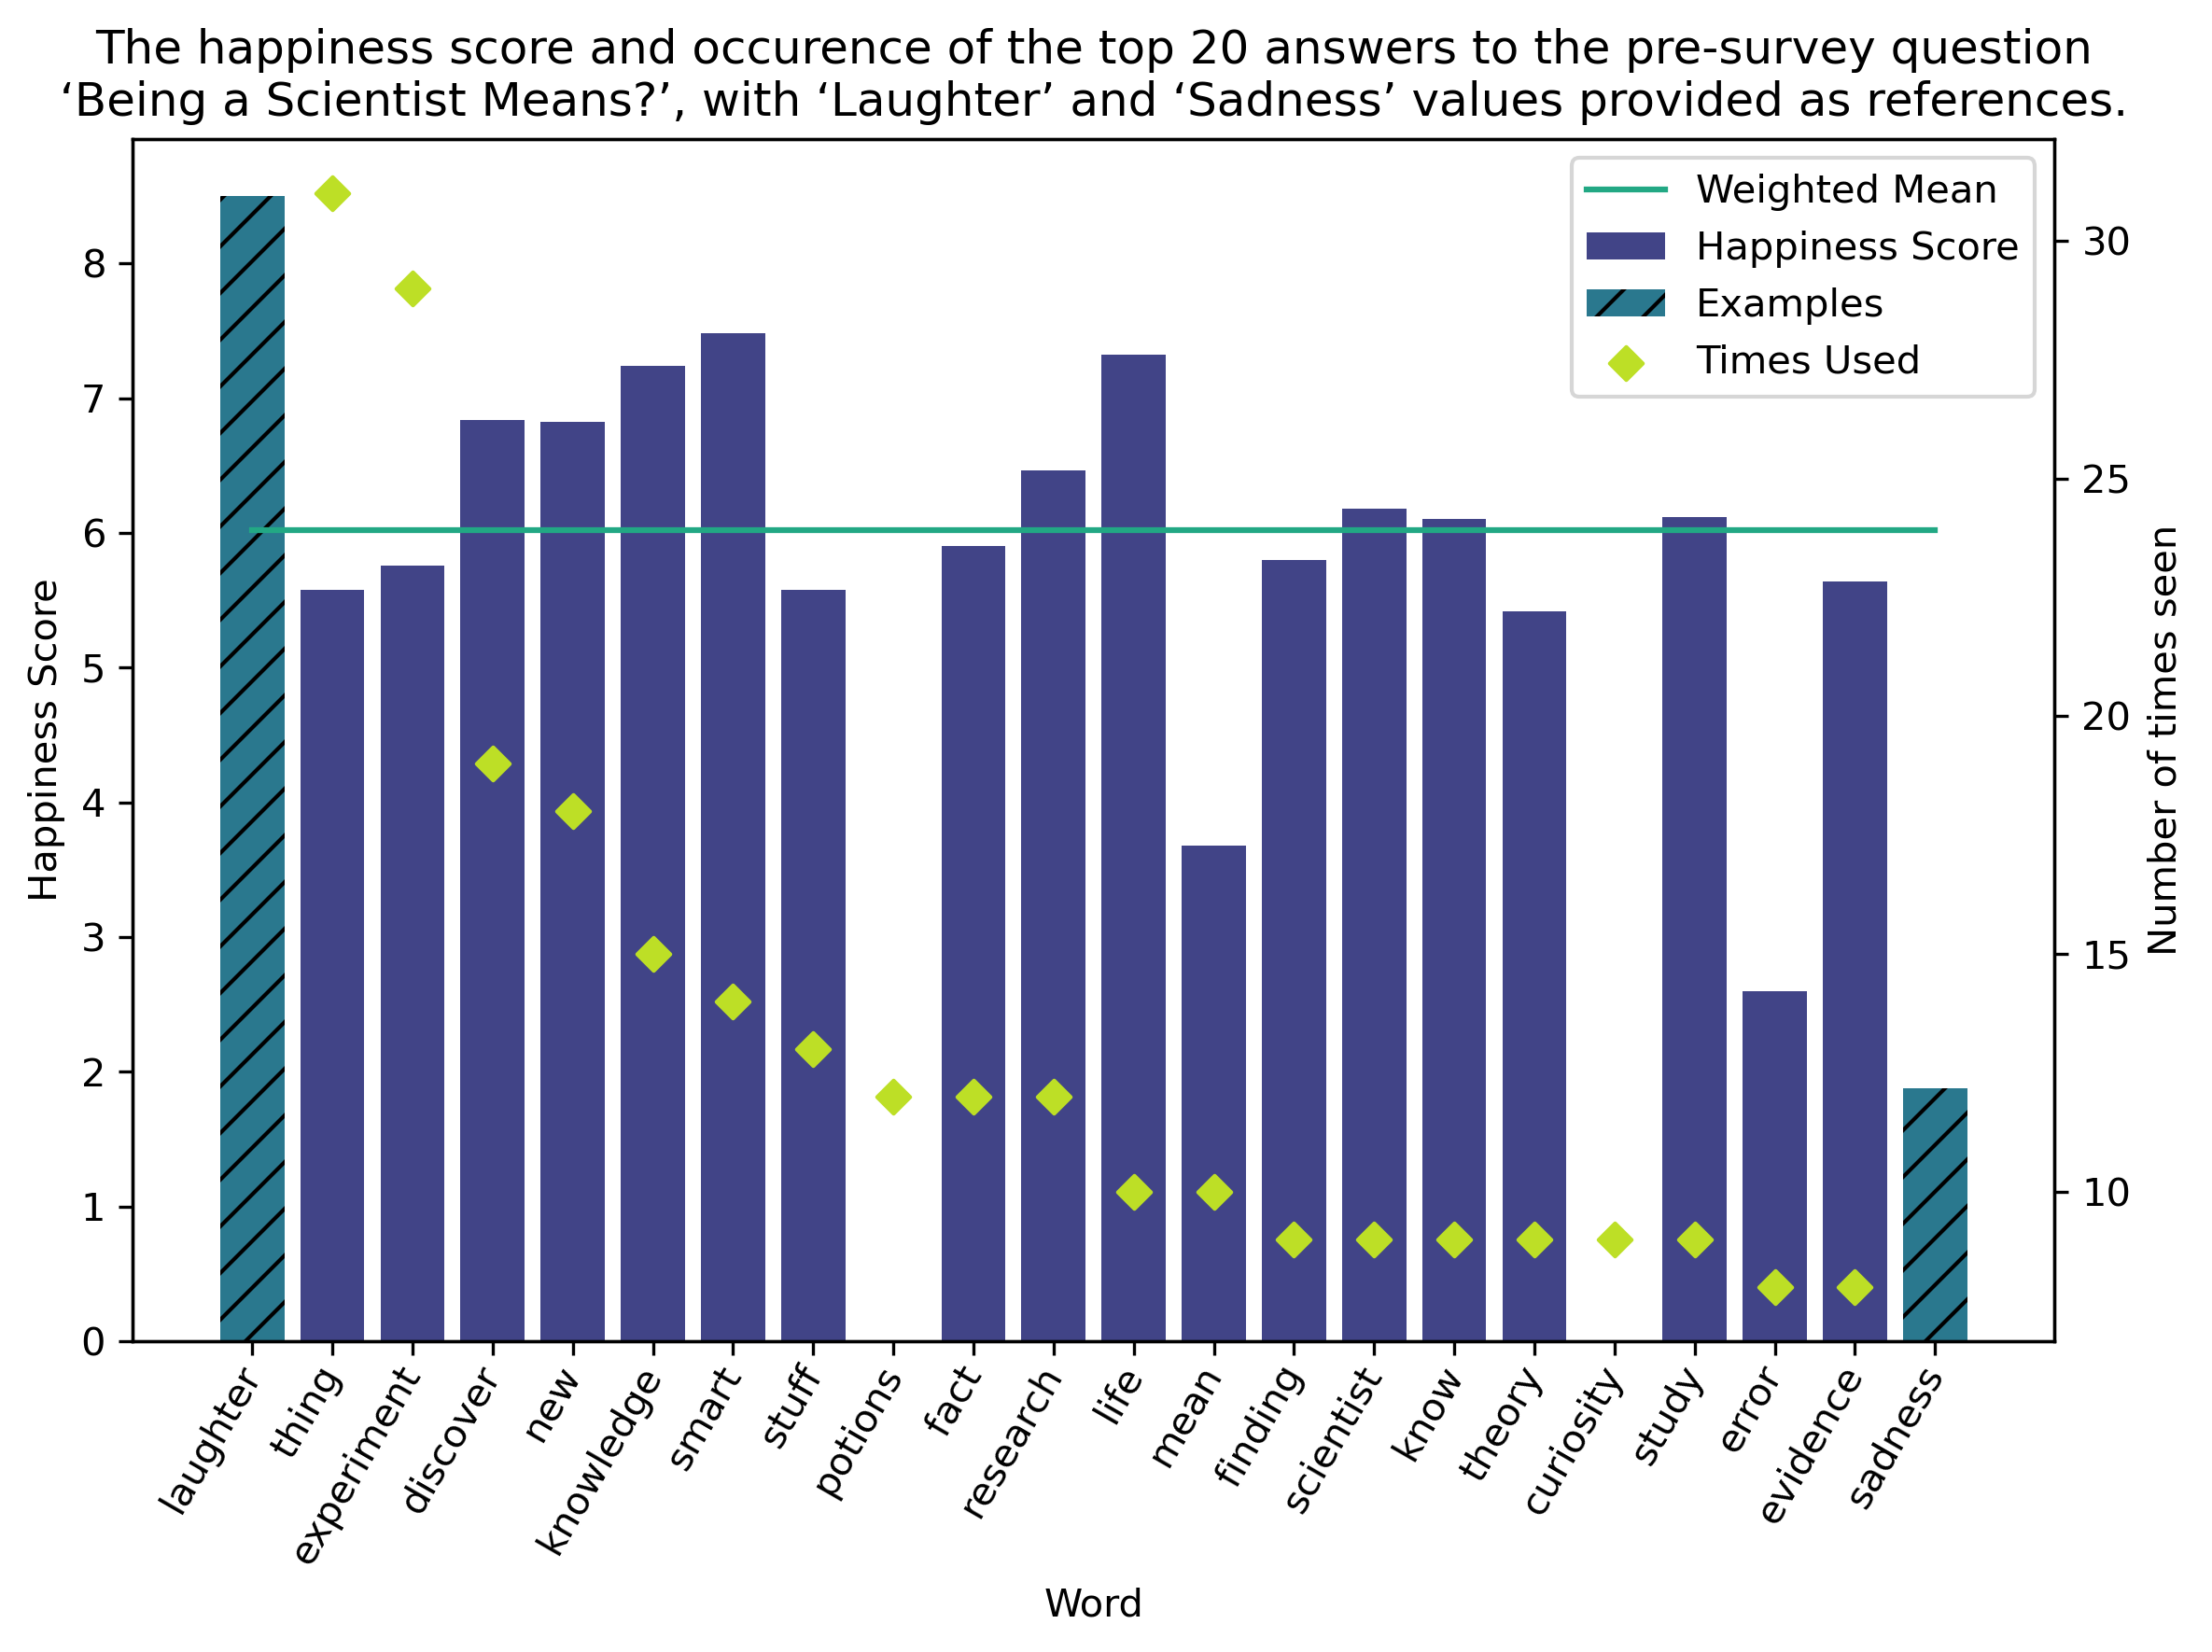

In [14]:
plot_word_analysis(rgs_df_before, 'RGSWordAnalyisBefore')

In [15]:
wordcloud.generate(' '.join(rgs_after_words))
rgs_df_after = create_top_word_dataframe(wordcloud, rgs_after_words)
rgs_df_after

,Word,Times used,Happiness Score,Happiness StDev,Examples,Weighted mean
0,laughter,NaN,8.50,NaN,8.50,6.069268
1,experiment,21.0,5.76,1.27,NaN,6.069268
2,thing,15.0,5.58,1.01,NaN,6.069268
3,science,8.0,6.86,1.58,NaN,6.069268
4,discovering,8.0,NaN,NaN,NaN,6.069268
5,learning,7.0,6.92,1.35,NaN,6.069268
6,new,7.0,6.82,1.14,NaN,6.069268
7,means,7.0,5.64,1.35,NaN,6.069268
8,scientist,6.0,6.18,1.29,NaN,6.069268
9,experimenting,6.0,NaN,NaN,NaN,6.069268


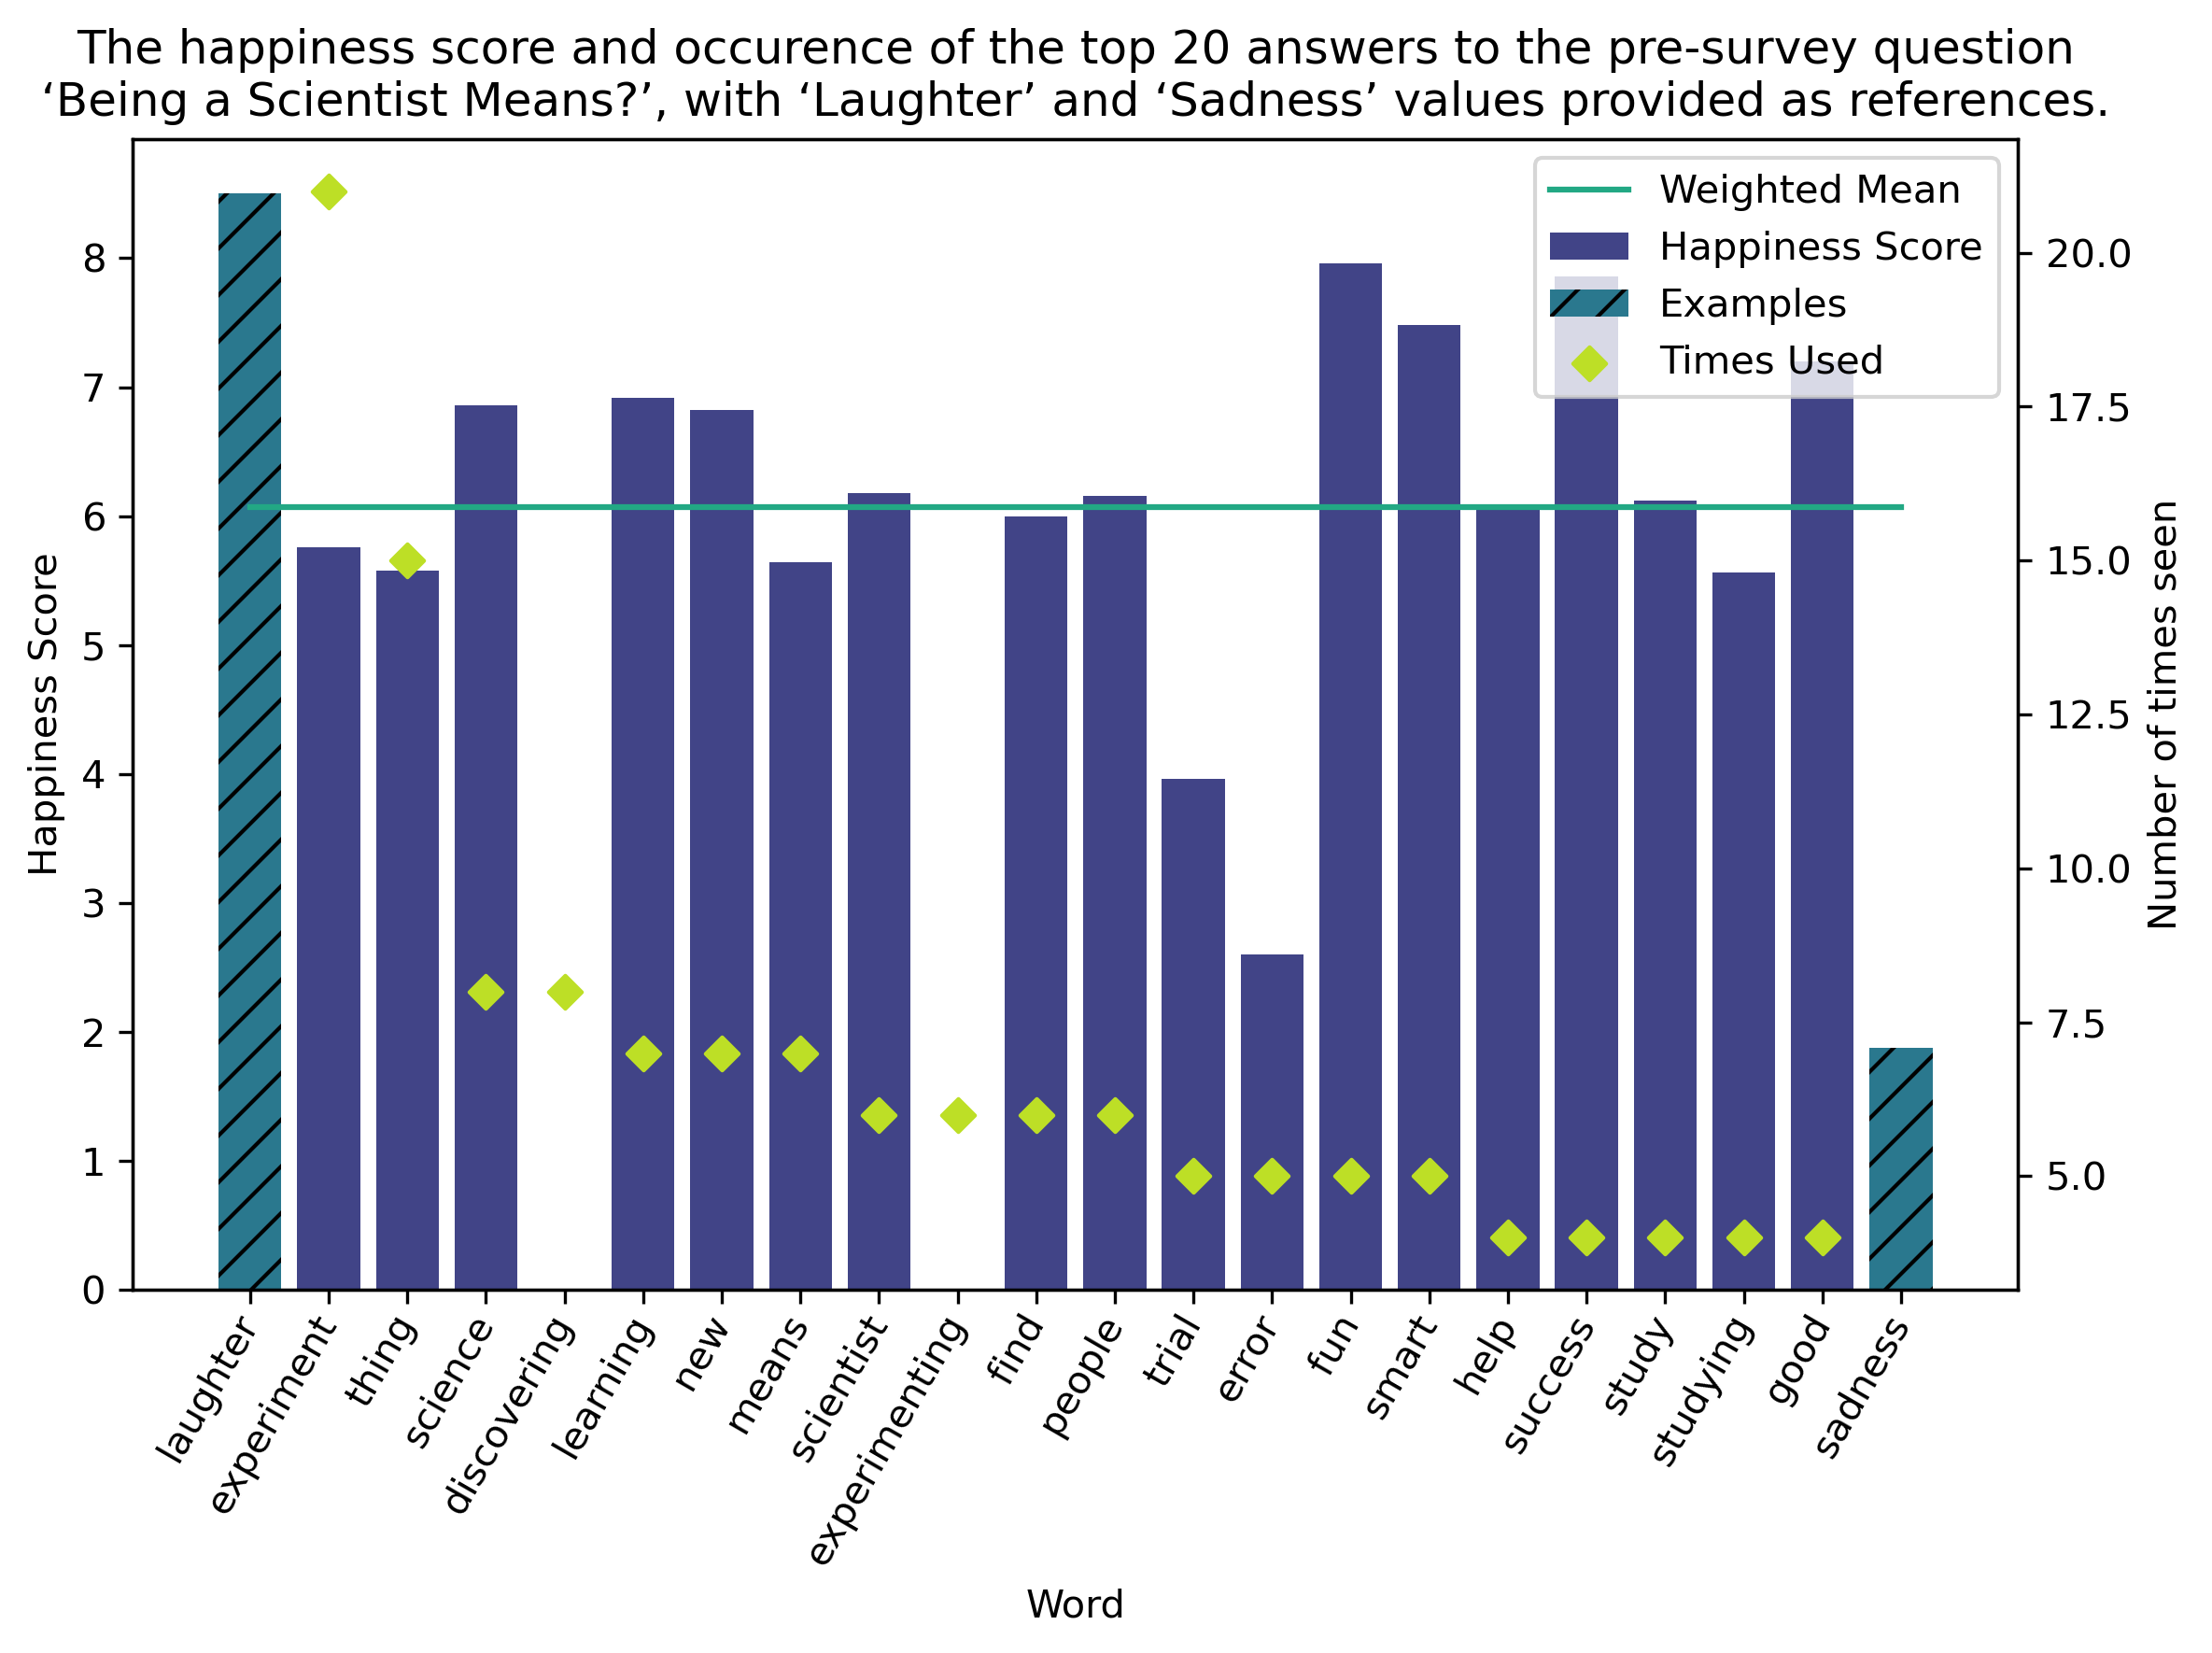

In [16]:
plot_word_analysis(rgs_df_after, 'RGSWordAnalyisAfter')

In [17]:
wordcloud.generate(' '.join(pnp_before_words))
pnp_df_before = create_top_word_dataframe(wordcloud, pnp_before_words)
pnp_df_before

,Word,Times used,Happiness Score,Happiness StDev,Examples,Weighted mean
0,laughter,NaN,8.50,NaN,8.50,6.277824
1,curiosity,47.0,NaN,NaN,NaN,6.277824
2,world,40.0,6.52,1.66,NaN,6.277824
3,exploring,39.0,NaN,NaN,NaN,6.277824
4,discovery,35.0,6.54,1.42,NaN,6.277824
5,curious,34.0,6.36,1.27,NaN,6.277824
6,fun,30.0,7.96,1.31,NaN,6.277824
7,thing,28.0,5.58,1.01,NaN,6.277824
8,learning,24.0,6.92,1.35,NaN,6.277824
9,discovering,22.0,NaN,NaN,NaN,6.277824


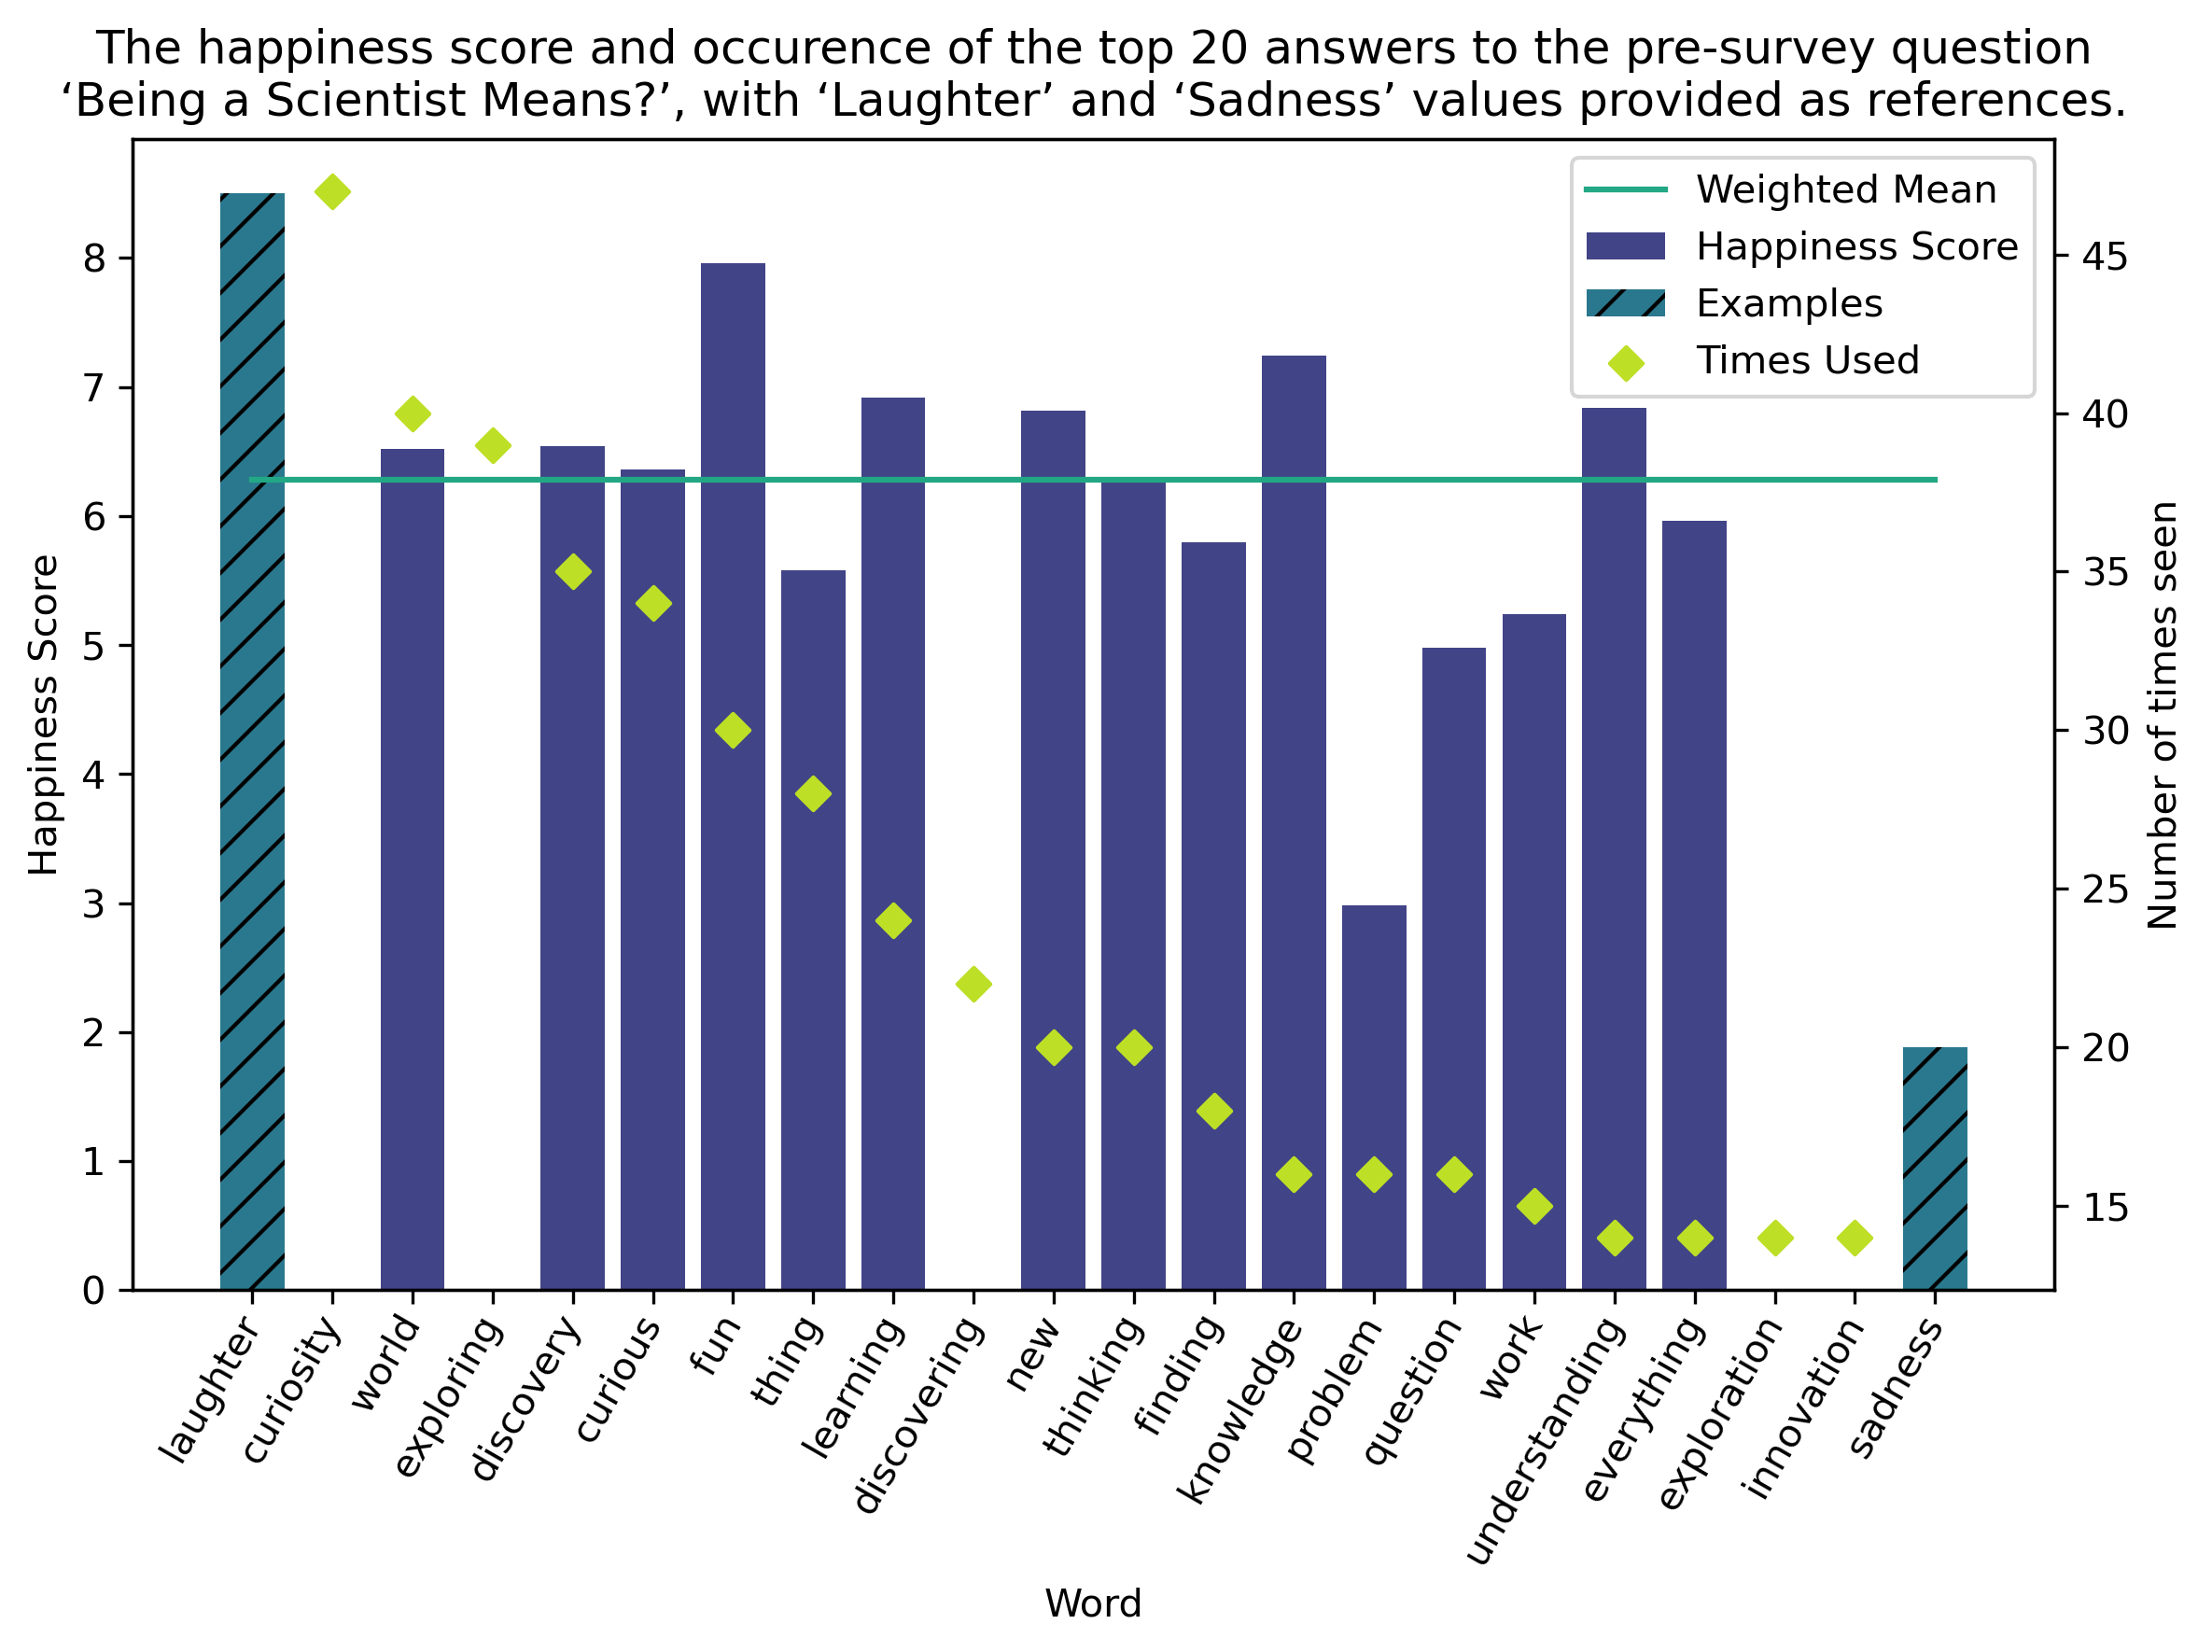

In [18]:
plot_word_analysis(pnp_df_before, 'PnPWordAnalyisBefore')